In [1]:
# import sys
# sys.path.insert(1, './wlcstat/')
import numpy as np
# import scipy.special as sp
# import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [ ]:
DONT WANT SINGLE CHAIN, want ensembe

Impact of Conformational and Chemical Correlations on Microphase Segregation in Random Copolymers

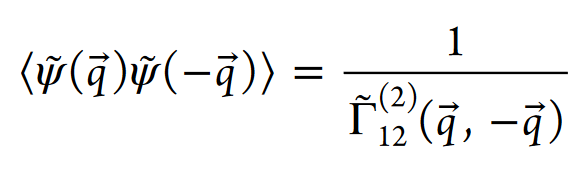

Fluctuation Effects in Semiflexible Diblock Copolymers

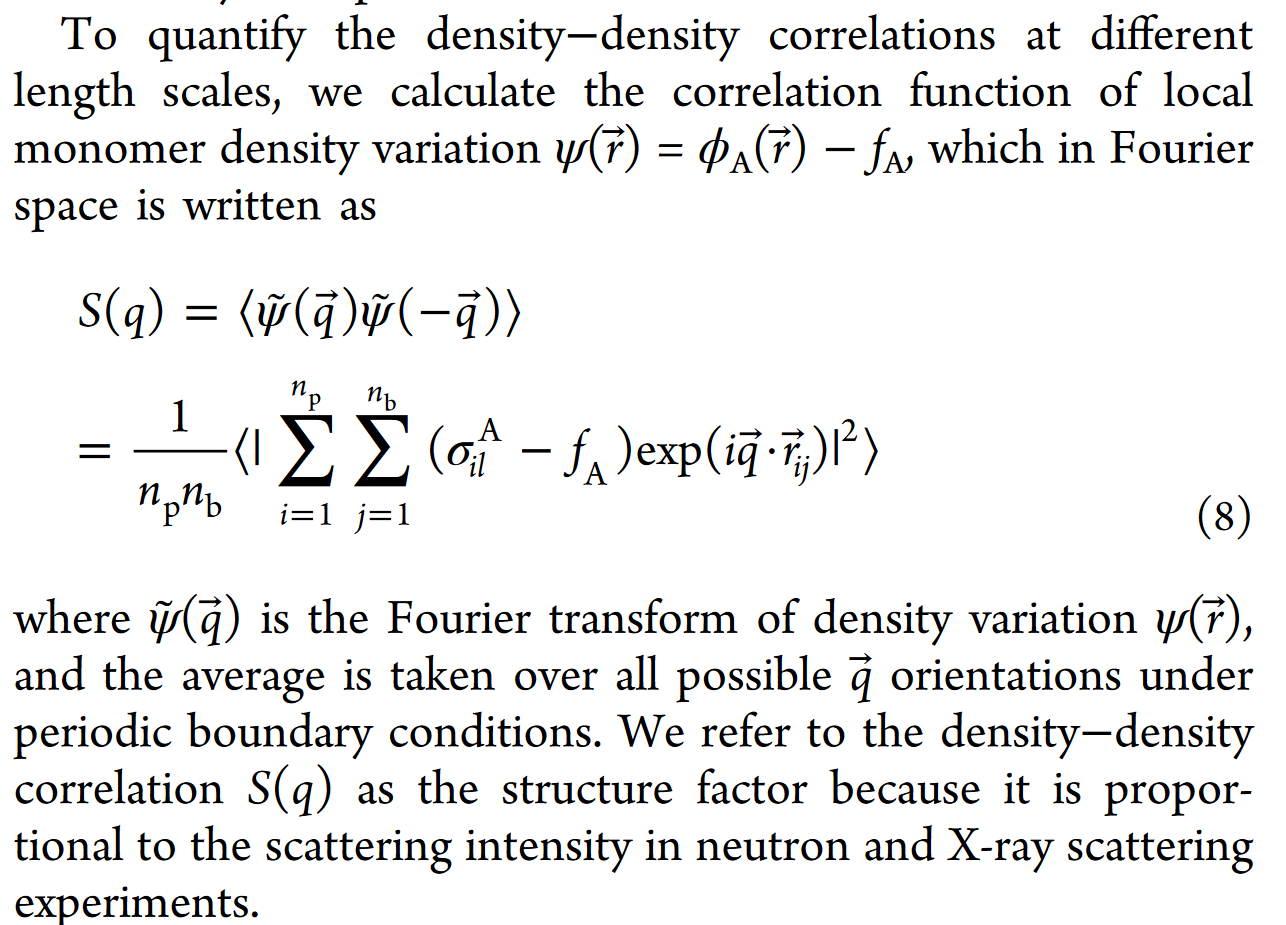

In [ ]:
TODO: This was for a melt. how to change for solution, where want A-A, A-B, B-B, A-S, B-S?
    ANSWER: just do magnitude of (sig_A - f_A)(sig_B - f_B)exp(2iqr)

## Theory

In [2]:
ID = -13.88
looping = "nuc, "
settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, chi, e_m, phi_c, poly_marks, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\chrom_stab\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],DNA,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

density_maps = np.load(r"ID=%s_density_maps.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [3]:
print("v_int: ")
print(v_int)

print(r"phi_c: ")
print(phi_c)

print("mu max, min, del_mu:")
print(mu_max, mu_min, del_mu) 

print("k logspace min, max, tot num:")
print(klog_min, klog_max, klog_num)

v_int: 
[[-4  0]
 [ 0 -4]]
phi_c: 
0.4
mu max, min, del_mu:
0.1 -9 0.1
k logspace min, max, tot num:
-2.5 -1 30


first generate spinodal diagram for system at given chi. \
Then determine a subset of mu1,mu2 systems that approach spinodal. \
then analyze density-density correlations in that system

In [40]:
# stab anal
chi = 0.
# chi = 30539.6/N

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
            min_eigval_arr_allk[i][j] = minval_allk
            
            min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
            k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

<Figure size 640x480 with 0 Axes>

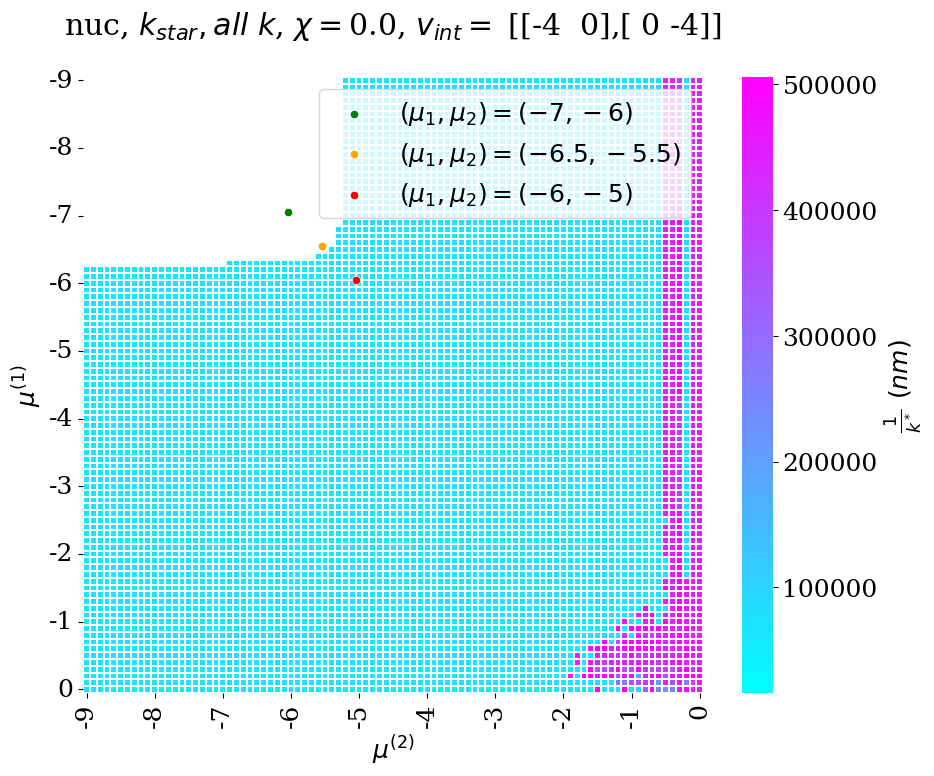

In [42]:
#density maps
# Explanation: first choose distances (in number of kuhn lengths) [or choose any length, then convert to # of kuhn lenghts]
# then invert these distances to get magnitudes of wavevectors
# then find k star, and invert it to get the critical lengthscale in units of number of kuhn lengths
# finally, (dimensional anaylsis) multiply critical lengthscale by kuhn length in nm to get lengthscale in nm!
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

k_star_arr[np.where(np.sign(min_eigval_arr_allk) == 1) ] = np.nan
ax = sns.heatmap(b*(1/(k_star_arr)), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array,\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"},\
                    vmin=b/(k_vec[-1]), vmax=b/(k_vec[0]))

ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(mu2_array[::spacing].astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(mu1_array[::spacing].astype(np.int64))


# plt.plot(27.3,10.5,'go') 
sns.scatterplot(x=[30],y=[20], color = "green", label = "$(\mu_1, \mu_2) = (-7, -6)$") 
sns.scatterplot(x=[35],y=[25], color = "orange", label = "$(\mu_1, \mu_2) = (-6.5, -5.5)$") 
sns.scatterplot(x=[40],y=[30], color = "red", label = "$(\mu_1, \mu_2) = (-6, -5)$") 

plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(looping + r"$ k_{star}, all \ k$" +  ", $\chi = $" + \
          str(np.round(chi*N, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()


In [59]:
np.where(np.round(mu1_array, 1) == -7)[0][0]

20

In [58]:
np.where(mu1_array == -7.)#[0][0]

(array([], dtype=int64),)

In [51]:
mu1_array[4]

-8.600000000000001

In [90]:
#dens-dens analysis
mu_pnts = np.array([[-7, -6],[-6.5, -5.5], [-6, -5]])
# stab anal

g1g1_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))
g1g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))
g2g2_corr_arr = np.zeros((len(mu_pnts), len(k_vec)))

# min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

# S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

# max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigval_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
# min_eigvec_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))
# k_star_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

A = 1/(b) # nm^2 cross sectional area
vol_nuc = A*(b) # volume of nucleosome

vol_solv = 1#N #1#10000000**3# (4e-10)**3

# for i, mu1 in enumerate(mu1_array[:]):
#     for j, mu2 in enumerate(mu2_array[:]):
        
for ind, mus in enumerate(mu_pnts):
#         if mu1 == mu2:
#             continue
        mu1, mu2 = mus
        i = np.where(np.round(mu1_array, 1) == mu1)[0][0]
        j = np.where(np.round(mu2_array, 1) == mu2)[0][0]
        
        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()
            S2_mat *= N*vol_nuc
            S2_mat[1][1] /= (N*vol_nuc)
            S2_mat[1][1] *= vol_solv

            if phi_c >= 0.999:
                raise Exception("melt!")
                
            
            # FULL SOLUTION 2 reader proteins
            S2_det = np.linalg.det(S2_mat)

#             S2_cond = np.linalg.cond(S2_mat)
#             S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0], S2_inv[2,3] + v_int[0,1]],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0], S2_inv[3,3] + v_int[1,1]]])
        
                G2_inv = np.linalg.inv(G2)
                g1g1_corr_arr[ind, ik] = G2_inv[1,1] # g1g1
                g1g2_corr_arr[ind, ik] = G2_inv[1,2] # g1g2
                g2g2_corr_arr[ind, ik] = G2_inv[2,2] # g1g2
#                 print(G2_inv[1,2])
#                 print(G2_inv[1,1])
#                 val, vec = np.linalg.eigh(G2)
#                 vec = vec.T
#                 min_val = np.min(val)            
#                 min_eigval_arr[i][j][ik] = min_val
#                 min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

        # all-k analysis
#         min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
#         min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
#         if len(min_vals) != 0:
#             minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             min_eigval_arr_allk[i][j] = minval_allk
            
#             min_eigvec_arr_allk[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
#             k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             k_star_arr[i][j] = k_star
        

# setting all non-decomposed/ separated systems to 0 
# poly_fluc = min_eigvec_arr_allk[:,:,0]
# poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot1_fluc = min_eigvec_arr_allk[:,:,1]
# prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

# prot2_fluc = min_eigvec_arr_allk[:,:,2]
# prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

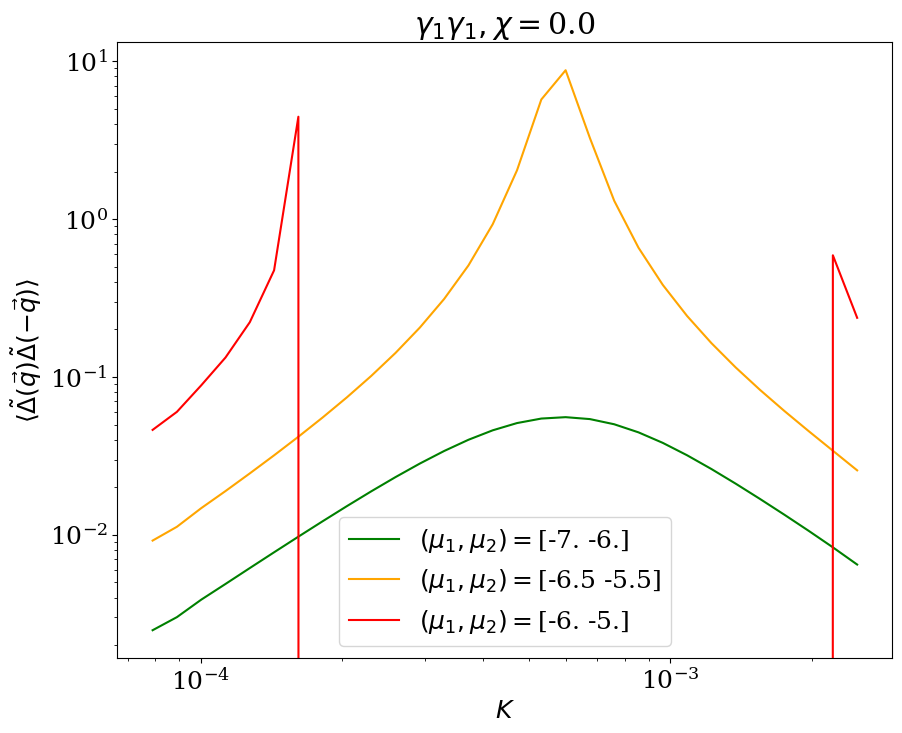

In [85]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_1, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g1_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g1g1_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g1g1_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

#why does it go negative in phase separated system?
# Correlation deiverges as g2 approaches 0. 
# Not physical to think about correlation past divergence, beyond just knowing that it indicates a phase separated system

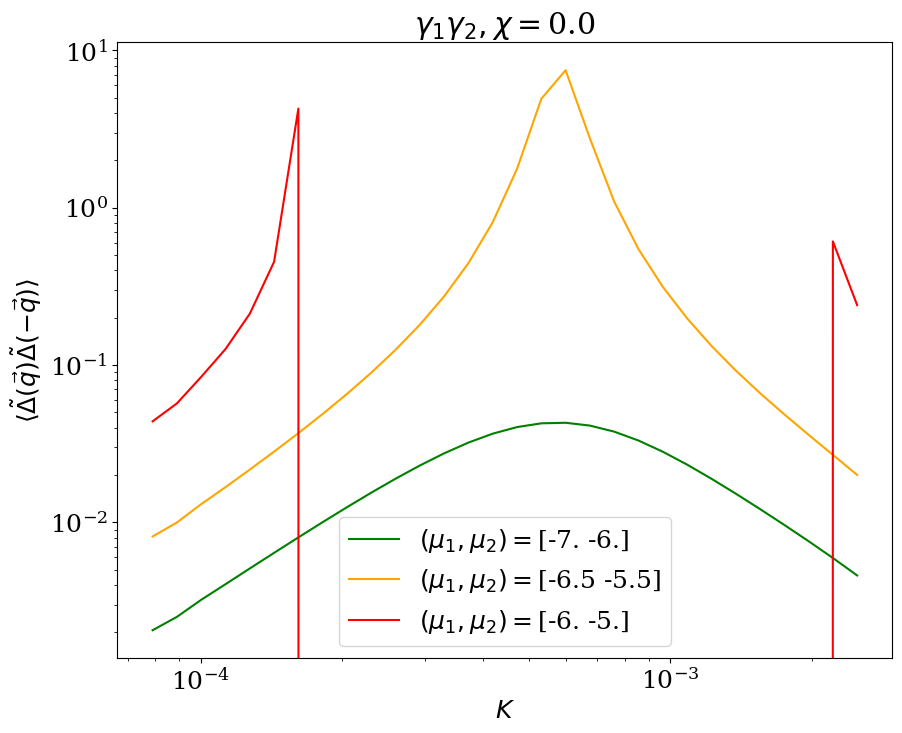

In [91]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_1 \gamma_2, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g1g2_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g1g2_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g1g2_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

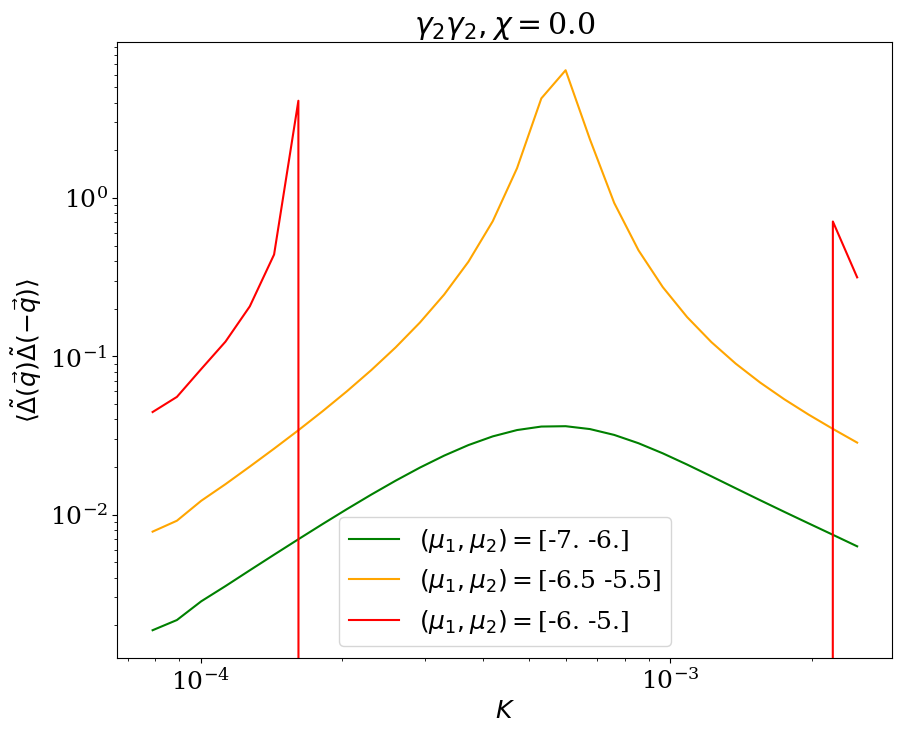

In [92]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.title("$\gamma_2 \gamma_2, \chi = $" + str(chi))
plt.xlabel(r'$K$')
plt.ylabel(r'$ \langle \tilde{\Delta}(\vec{q}) \tilde{\Delta}(-\vec{q})  \rangle$')

plt.plot(k_vec, g2g2_corr_arr[0], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[0]), color = "green")
plt.plot(k_vec, g2g2_corr_arr[1], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[1]), color = "orange")
plt.plot(k_vec, g2g2_corr_arr[2], label = "$(\mu_1, \mu_2) =$" + str(mu_pnts[2]), color = "red")
plt.legend()
plt.xscale('log')
plt.yscale('log')

## Simulation

In [ ]:
TODO: Edit for chromo!

def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
        comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

def get_sigma_array(df, bead_type):
    sigma = np.array([])
    
    if bead_type == "A":
        sigma = df.Type
        
    elif bead_type == "B": #reverse the sigma 
        sigma = df.Type.replace([0, 1], [1, 0])
        
    return sigma

def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly=1, l_box=20, bead_type = "A"):
    '''
    structure factor. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
    with the same magnitude)  
    q_vectors is a list of vectors with same magnitude
    '''
    if bead_type == "Solvent":
        print("CANT GET SOLVENT SF FROM POSITIONS")
        return wrong
    
    sigma = get_sigma_array(df, bead_type)
                
    sum_avg = 0
    for q_vect in q_vectors:
        summ = 0
        A = sigma - f_A*phi_poly #replaced df.Type with sigma
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    
def get_bin_ind_dict(num_bins_per_side):
    '''
    returns a dictionary that maps the 1D bin index in the sim output to the 3D bin position
    '''
    tot_num_bins = num_bins_per_side**3
    indicies = np.arange(1, tot_num_bins+1)
    bin_ind_dict = {}

    for iz in np.arange(1,num_bins_per_side + 1):
        for iy in np.arange(1,num_bins_per_side + 1):
            for ix in np.arange(1,num_bins_per_side + 1):
                threeD_ind = [ix, iy, iz]
                threeD_position = [ix-0.5, iy-0.5, iz-0.5]
                oneD_ind = (ix + (iy-1)*num_bins_per_side + (iz-1)*num_bins_per_side**2) - 1 # from mc_int.f03. subtract 1 for python 0 indexing
                bin_ind_dict[oneD_ind] = threeD_position
                
    return bin_ind_dict

def structure_factor_from_sim_bins(df, q_vectors,  bin_pos_array, tot_num_bins, bead_type = "A"):
    '''
    structure factor from bins. Calculates the value of the structure factor for a single magnitude of q (set of q vectors 
    with the same magnitude)  
    q_vectors is a list of vectors with same magnitude
    '''
    #tot_num_bins = num_bins_per_side**2
    #bin_ind_dict = get_bin_ind_dict(num_bins_per_side)
    #bin_pos_array = np.array(list(bin_ind_dict.values()))  #can move these lines out
    
    if bead_type == "A":
        phis = df.Phi_A
    elif bead_type == "B":
        phis = df.Phi_B
    elif bead_type == "Solvent":
        phi_poly = df.Phi_A + df.Phi_B
        phis = 1-phi_poly
        phis[phis < 0] = 0
        
    sum_avg = 0
    for q_vect in q_vectors:
        summ = 0
        A = phis #"BIN VOLUME FRACTION"
        B = 1j*np.dot(bin_pos_array, q_vect) #bin pos
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
        with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
            test_data = {"phis": A, 'exp_arg': B, 'eval_exp':np.exp(B), "eval_exp * phi": A*np.exp(B)}
            daf = pd.DataFrame(test_data)
            print(summ)
            print(daf)
    return sum_avg * (1/tot_num_bins)

In [ ]:
%%time

df_chi_list = []
chi_list = []
lam_list = []
EPS_list = []
L0_list = []
n_p_list = []

for pth in path_list:
    
    data_path = pth[0]
    consts_path = pth[1]
    os.chdir(data_path)
    
    if data_path[-3] == "r": # means a folder of position files:
        name_list = ["X", "Y", "Z", "Type"]
    elif data_path[-5] == "p": # folder of vol frac files
        name_list = ["Phi_A", "Phi_B"]
     
    df_list = []
    for file in os.listdir():
        file_path = f"{data_path}\{file}"
        file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)
        df_list.append(file_df)
    consts =  pd.read_csv(consts_path, header=None, names = ["const", "value"])#, names = name_list, delim_whitespace=True)
    chi_list.append(consts.iloc[0, 1])
    lam_list.append(consts.iloc[1, 1])
    EPS_list.append(consts.iloc[2, 1])
    L0_list.append(consts.iloc[3, 1])
    n_p_list.append(consts.iloc[4, 1])
    df_chi_list.append([df_list, consts.iloc[0, 1], consts.iloc[4, 1]]) #list of data frames and their chi value and num polymers
    
    
#MOST ROBUST SOLUTION
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
sort_mags = np.array(sorted_magnitudes)           

# for phi sf calculations
tot_num_bins = num_bins_per_side**2
bin_ind_dict = get_bin_ind_dict(num_bins_per_side)
bin_pos_array = np.array(list(bin_ind_dict.values())) # array of bin positions that correspond to 1D bin index

structure_fact_array_list = []
for df_pair in df_chi_list:
    df_list = df_pair[0]
    chi_value = df_pair[1]
    n_p = df_pair[2]
    phi_poly = n_p/2000
    print(n_p)

    structure_fact_array = np.array([])
    for mag in sorted_magnitudes:
        q_vectors = mag_vects_map[mag]
        sf_average = 0
        from_bins = None
        for df in df_list: #avging over ensembles
            if df.columns[0] == "X": # position data
                from_bins = False
                sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20, bead_type = bd_type)
            elif df.columns[0] == "Phi_A": # bin data
                from_bins = True
                sf = structure_factor_from_sim_bins(df, q_vectors, bin_pos_array, tot_num_bins, bead_type = bd_type)
            sf_average += sf/(len(df_list)) 
        structure_fact_array = np.append(structure_fact_array, sf_average)
    structure_fact_array_list.append([structure_fact_array, chi_value, phi_poly, from_bins])